In [8]:
### CONFIG ###
from trafficgraphnn.sumo_network import SumoNetwork

sn = SumoNetwork(
    'data/networks/simonnet/simonnet.net.xml', routefile='data/networks/simonnet/simonnet_rand_routes.routes.xml',
    lanewise=True, addlfiles=['data/networks/simonnet/simonnet_e1.add.xml', 'data/networks/simonnet/simonnet_e2.add.xml', 'data/networks/simonnet/tls_output.add.xml']
)
#sn.run()

In [32]:
from trafficgraphnn.preprocess_data import PreprocessData
preprocess = PreprocessData(sn)

A, X_train_tens, X_test_tens, X_val_tens = preprocess.preprocess_for_gat(average_interval = 50)
print('X_train shape:', X_train_tens.shape)
print('X_test shape:', X_test_tens.shape)
print('X_val shape:', X_val_tens.shape)
A = np.eye(120,120) + A
#print('Adjacency matrix:', A)

timestep: 200
timestep: 250
timestep: 300
timestep: 350
timestep: 400
timestep: 450
timestep: 500
timestep: 550
timestep: 600
timestep: 650
timestep: 700
timestep: 750
timestep: 800
timestep: 850
timestep: 900
timestep: 950
timestep: 1000
timestep: 1050
timestep: 1100
timestep: 1150
timestep: 1200
timestep: 1250
timestep: 1300
timestep: 1350
timestep: 1400
timestep: 1450
timestep: 1500
timestep: 1550
timestep: 1600
timestep: 1650
X_train shape: (120, 8, 10)
X_test shape: (120, 8, 10)
X_val shape: (120, 8, 10)


In [33]:
from __future__ import division
import numpy as np

import tensorflow as tf
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Input, Dropout, Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, Adagrad
from keras.regularizers import l2

from keras_gat import GraphAttention
from keras_gat.utils import load_data


(120, 8, 10)
N: 120
F: 8
F_: 8
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 8)            0                                            
__________________________________________________________________________________________________
dropout_121 (Dropout)           (None, 8)            0           input_21[0][0]                   
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 120)          0                                            
__________________________________________________________________________________________________
graph_attention_21 (GraphAttent (None, 250)          2500        dropout_121[0][0]                
                                                                 input_22[0][0

Epoch 39/2000
120/120 [==============================] - 0s 397us/step - loss: 3706.5437 - weighted_acc: 0.5417 - val_loss: 3676.6011 - val_weighted_acc: 0.5667
Epoch 40/2000
120/120 [==============================] - 0s 379us/step - loss: 3676.6011 - weighted_acc: 0.5667 - val_loss: 3664.7180 - val_weighted_acc: 0.5500
Epoch 41/2000
120/120 [==============================] - 0s 352us/step - loss: 3664.7180 - weighted_acc: 0.5500 - val_loss: 3609.4690 - val_weighted_acc: 0.5417
Epoch 42/2000
120/120 [==============================] - 0s 359us/step - loss: 3609.4690 - weighted_acc: 0.5417 - val_loss: 3581.3157 - val_weighted_acc: 0.5583
Epoch 43/2000
120/120 [==============================] - 0s 346us/step - loss: 3581.3157 - weighted_acc: 0.5583 - val_loss: 3558.8718 - val_weighted_acc: 0.5417
Epoch 44/2000
120/120 [==============================] - 0s 372us/step - loss: 3558.8718 - weighted_acc: 0.5417 - val_loss: 3482.9458 - val_weighted_acc: 0.5500
Epoch 45/2000
120/120 [===========

Epoch 90/2000
120/120 [==============================] - 0s 363us/step - loss: 2844.3816 - weighted_acc: 0.6500 - val_loss: 2837.1692 - val_weighted_acc: 0.6167
Epoch 91/2000
120/120 [==============================] - 0s 377us/step - loss: 2837.1692 - weighted_acc: 0.6167 - val_loss: 2837.4365 - val_weighted_acc: 0.6417
Epoch 92/2000
120/120 [==============================] - 0s 406us/step - loss: 2837.4365 - weighted_acc: 0.6417 - val_loss: 2829.6653 - val_weighted_acc: 0.6500
Epoch 93/2000
120/120 [==============================] - 0s 332us/step - loss: 2829.6653 - weighted_acc: 0.6500 - val_loss: 2831.5977 - val_weighted_acc: 0.6333
Epoch 94/2000
120/120 [==============================] - 0s 330us/step - loss: 2831.5977 - weighted_acc: 0.6333 - val_loss: 2812.4233 - val_weighted_acc: 0.6250
Epoch 95/2000
120/120 [==============================] - 0s 395us/step - loss: 2812.4233 - weighted_acc: 0.6250 - val_loss: 2813.4419 - val_weighted_acc: 0.6333
Epoch 96/2000
120/120 [===========

Epoch 141/2000
120/120 [==============================] - 0s 392us/step - loss: 2519.1357 - weighted_acc: 0.6750 - val_loss: 2503.4463 - val_weighted_acc: 0.6667
Epoch 142/2000
120/120 [==============================] - 0s 346us/step - loss: 2503.4463 - weighted_acc: 0.6667 - val_loss: 2497.4712 - val_weighted_acc: 0.6750
Epoch 143/2000
120/120 [==============================] - 0s 326us/step - loss: 2497.4712 - weighted_acc: 0.6750 - val_loss: 2486.0938 - val_weighted_acc: 0.6667
Epoch 144/2000
120/120 [==============================] - 0s 378us/step - loss: 2486.0938 - weighted_acc: 0.6667 - val_loss: 2485.0522 - val_weighted_acc: 0.6750
Epoch 145/2000
120/120 [==============================] - 0s 344us/step - loss: 2485.0522 - weighted_acc: 0.6750 - val_loss: 2464.7927 - val_weighted_acc: 0.6667
Epoch 146/2000
120/120 [==============================] - 0s 350us/step - loss: 2464.7927 - weighted_acc: 0.6667 - val_loss: 2459.2019 - val_weighted_acc: 0.6833
Epoch 147/2000
120/120 [====

Epoch 192/2000
120/120 [==============================] - 0s 334us/step - loss: 2309.7510 - weighted_acc: 0.6667 - val_loss: 2289.2354 - val_weighted_acc: 0.6750
Epoch 193/2000
120/120 [==============================] - 0s 365us/step - loss: 2289.2354 - weighted_acc: 0.6750 - val_loss: 2323.1672 - val_weighted_acc: 0.6667
Epoch 194/2000
120/120 [==============================] - 0s 347us/step - loss: 2323.1672 - weighted_acc: 0.6667 - val_loss: 2287.6370 - val_weighted_acc: 0.6750
Epoch 195/2000
120/120 [==============================] - 0s 353us/step - loss: 2287.6370 - weighted_acc: 0.6750 - val_loss: 2343.4968 - val_weighted_acc: 0.6583
Epoch 196/2000
120/120 [==============================] - 0s 327us/step - loss: 2343.4968 - weighted_acc: 0.6583 - val_loss: 2360.6697 - val_weighted_acc: 0.6917
Epoch 197/2000
120/120 [==============================] - 0s 319us/step - loss: 2360.6697 - weighted_acc: 0.6917 - val_loss: 2372.5479 - val_weighted_acc: 0.6667
Epoch 198/2000
120/120 [====

Epoch 243/2000
120/120 [==============================] - 0s 361us/step - loss: 2441.4929 - weighted_acc: 0.6917 - val_loss: 2437.6494 - val_weighted_acc: 0.6917
Epoch 244/2000
120/120 [==============================] - 0s 389us/step - loss: 2437.6494 - weighted_acc: 0.6917 - val_loss: 2438.7827 - val_weighted_acc: 0.6917
Epoch 245/2000
120/120 [==============================] - 0s 384us/step - loss: 2438.7827 - weighted_acc: 0.6917 - val_loss: 2451.9697 - val_weighted_acc: 0.6917
Epoch 246/2000
120/120 [==============================] - 0s 359us/step - loss: 2451.9697 - weighted_acc: 0.6917 - val_loss: 2427.4783 - val_weighted_acc: 0.6833
Epoch 247/2000
120/120 [==============================] - 0s 369us/step - loss: 2427.4783 - weighted_acc: 0.6833 - val_loss: 2412.4644 - val_weighted_acc: 0.7000
Epoch 248/2000
120/120 [==============================] - 0s 379us/step - loss: 2412.4644 - weighted_acc: 0.7000 - val_loss: 2427.7876 - val_weighted_acc: 0.6917
Epoch 249/2000
120/120 [====

Epoch 294/2000
120/120 [==============================] - 0s 351us/step - loss: 2269.1523 - weighted_acc: 0.7167 - val_loss: 2266.3235 - val_weighted_acc: 0.7167
Epoch 295/2000
120/120 [==============================] - 0s 324us/step - loss: 2266.3235 - weighted_acc: 0.7167 - val_loss: 2263.6416 - val_weighted_acc: 0.7167
Epoch 296/2000
120/120 [==============================] - 0s 371us/step - loss: 2263.6416 - weighted_acc: 0.7167 - val_loss: 2261.5039 - val_weighted_acc: 0.7083
Epoch 297/2000
120/120 [==============================] - 0s 307us/step - loss: 2261.5039 - weighted_acc: 0.7083 - val_loss: 2260.9922 - val_weighted_acc: 0.7167
Epoch 298/2000
120/120 [==============================] - 0s 361us/step - loss: 2260.9922 - weighted_acc: 0.7167 - val_loss: 2267.4275 - val_weighted_acc: 0.7167
Epoch 299/2000
120/120 [==============================] - 0s 358us/step - loss: 2267.4275 - weighted_acc: 0.7167 - val_loss: 2248.9856 - val_weighted_acc: 0.7167
Epoch 300/2000
120/120 [====

Epoch 345/2000
120/120 [==============================] - 0s 370us/step - loss: 2196.3367 - weighted_acc: 0.7167 - val_loss: 2185.8584 - val_weighted_acc: 0.7167
Epoch 346/2000
120/120 [==============================] - 0s 370us/step - loss: 2185.8584 - weighted_acc: 0.7167 - val_loss: 2187.7439 - val_weighted_acc: 0.7250
Epoch 347/2000
120/120 [==============================] - 0s 365us/step - loss: 2187.7439 - weighted_acc: 0.7250 - val_loss: 2188.0789 - val_weighted_acc: 0.7167
Epoch 348/2000
120/120 [==============================] - 0s 348us/step - loss: 2188.0789 - weighted_acc: 0.7167 - val_loss: 2201.1641 - val_weighted_acc: 0.7250
Epoch 349/2000
120/120 [==============================] - 0s 359us/step - loss: 2201.1641 - weighted_acc: 0.7250 - val_loss: 2182.9475 - val_weighted_acc: 0.7083
Epoch 350/2000
120/120 [==============================] - 0s 364us/step - loss: 2182.9475 - weighted_acc: 0.7083 - val_loss: 2174.2529 - val_weighted_acc: 0.7250
Epoch 351/2000
120/120 [====

Epoch 396/2000
120/120 [==============================] - 0s 359us/step - loss: 2095.0081 - weighted_acc: 0.7167 - val_loss: 2097.6436 - val_weighted_acc: 0.7083
Epoch 397/2000
120/120 [==============================] - 0s 337us/step - loss: 2097.6436 - weighted_acc: 0.7083 - val_loss: 2093.9158 - val_weighted_acc: 0.7167
Epoch 398/2000
120/120 [==============================] - 0s 341us/step - loss: 2093.9158 - weighted_acc: 0.7167 - val_loss: 2098.5266 - val_weighted_acc: 0.7083
Epoch 399/2000
120/120 [==============================] - 0s 334us/step - loss: 2098.5266 - weighted_acc: 0.7083 - val_loss: 2089.9709 - val_weighted_acc: 0.7167
Epoch 400/2000
120/120 [==============================] - 0s 371us/step - loss: 2089.9709 - weighted_acc: 0.7167 - val_loss: 2090.1501 - val_weighted_acc: 0.7083
Epoch 401/2000
120/120 [==============================] - 0s 360us/step - loss: 2090.1501 - weighted_acc: 0.7083 - val_loss: 2089.2915 - val_weighted_acc: 0.7167
Epoch 402/2000
120/120 [====

Epoch 447/2000
120/120 [==============================] - 0s 337us/step - loss: 2020.9531 - weighted_acc: 0.7083 - val_loss: 2020.1376 - val_weighted_acc: 0.7167
Epoch 448/2000
120/120 [==============================] - 0s 390us/step - loss: 2020.1376 - weighted_acc: 0.7167 - val_loss: 2022.0216 - val_weighted_acc: 0.7083
Epoch 449/2000
120/120 [==============================] - 0s 338us/step - loss: 2022.0216 - weighted_acc: 0.7083 - val_loss: 2020.2417 - val_weighted_acc: 0.7167
Epoch 450/2000
120/120 [==============================] - 0s 329us/step - loss: 2020.2417 - weighted_acc: 0.7167 - val_loss: 2026.1089 - val_weighted_acc: 0.7083
Epoch 451/2000
120/120 [==============================] - 0s 355us/step - loss: 2026.1089 - weighted_acc: 0.7083 - val_loss: 2016.5122 - val_weighted_acc: 0.7167
Epoch 452/2000
120/120 [==============================] - 0s 333us/step - loss: 2016.5122 - weighted_acc: 0.7167 - val_loss: 2015.4331 - val_weighted_acc: 0.7083
Epoch 453/2000
120/120 [====

Epoch 498/2000
120/120 [==============================] - 0s 374us/step - loss: 1966.8972 - weighted_acc: 0.7083 - val_loss: 1971.2194 - val_weighted_acc: 0.7000
Epoch 499/2000
120/120 [==============================] - 0s 335us/step - loss: 1971.2194 - weighted_acc: 0.7000 - val_loss: 1963.8387 - val_weighted_acc: 0.7083
Epoch 500/2000
120/120 [==============================] - 0s 364us/step - loss: 1963.8387 - weighted_acc: 0.7083 - val_loss: 1964.0465 - val_weighted_acc: 0.7000
Epoch 501/2000
120/120 [==============================] - 0s 331us/step - loss: 1964.0465 - weighted_acc: 0.7000 - val_loss: 1963.9781 - val_weighted_acc: 0.7083
Epoch 502/2000
120/120 [==============================] - 0s 482us/step - loss: 1963.9781 - weighted_acc: 0.7083 - val_loss: 1970.0896 - val_weighted_acc: 0.7000
Epoch 503/2000
120/120 [==============================] - 0s 335us/step - loss: 1970.0896 - weighted_acc: 0.7000 - val_loss: 1959.7489 - val_weighted_acc: 0.7083
Epoch 504/2000
120/120 [====

Epoch 549/2000
120/120 [==============================] - 0s 355us/step - loss: 1916.3396 - weighted_acc: 0.7000 - val_loss: 1919.6813 - val_weighted_acc: 0.7083
Epoch 550/2000
120/120 [==============================] - 0s 376us/step - loss: 1919.6813 - weighted_acc: 0.7083 - val_loss: 1922.8964 - val_weighted_acc: 0.7000
Epoch 551/2000
120/120 [==============================] - 0s 320us/step - loss: 1922.8964 - weighted_acc: 0.7000 - val_loss: 1913.5591 - val_weighted_acc: 0.7083
Epoch 552/2000
120/120 [==============================] - 0s 313us/step - loss: 1913.5591 - weighted_acc: 0.7083 - val_loss: 1913.5057 - val_weighted_acc: 0.7000
Epoch 553/2000
120/120 [==============================] - 0s 400us/step - loss: 1913.5057 - weighted_acc: 0.7000 - val_loss: 1916.6344 - val_weighted_acc: 0.7083
Epoch 554/2000
120/120 [==============================] - 0s 357us/step - loss: 1916.6344 - weighted_acc: 0.7083 - val_loss: 1920.2740 - val_weighted_acc: 0.7000
Epoch 555/2000
120/120 [====

Epoch 600/2000
120/120 [==============================] - 0s 341us/step - loss: 1875.9247 - weighted_acc: 0.7083 - val_loss: 1877.3263 - val_weighted_acc: 0.7083
Epoch 601/2000
120/120 [==============================] - 0s 346us/step - loss: 1877.3263 - weighted_acc: 0.7083 - val_loss: 1879.2589 - val_weighted_acc: 0.7083
Epoch 602/2000
120/120 [==============================] - 0s 345us/step - loss: 1879.2589 - weighted_acc: 0.7083 - val_loss: 1880.6776 - val_weighted_acc: 0.7083
Epoch 603/2000
120/120 [==============================] - 0s 323us/step - loss: 1880.6776 - weighted_acc: 0.7083 - val_loss: 1872.6062 - val_weighted_acc: 0.7083
Epoch 604/2000
120/120 [==============================] - 0s 336us/step - loss: 1872.6062 - weighted_acc: 0.7083 - val_loss: 1874.2130 - val_weighted_acc: 0.7083
Epoch 605/2000
120/120 [==============================] - 0s 335us/step - loss: 1874.2130 - weighted_acc: 0.7083 - val_loss: 1875.5198 - val_weighted_acc: 0.7083
Epoch 606/2000
120/120 [====

Epoch 651/2000
120/120 [==============================] - 0s 331us/step - loss: 1842.3132 - weighted_acc: 0.7083 - val_loss: 1837.0308 - val_weighted_acc: 0.7167
Epoch 652/2000
120/120 [==============================] - 0s 352us/step - loss: 1837.0308 - weighted_acc: 0.7167 - val_loss: 1839.7875 - val_weighted_acc: 0.7083
Epoch 653/2000
120/120 [==============================] - 0s 345us/step - loss: 1839.7875 - weighted_acc: 0.7083 - val_loss: 1840.8635 - val_weighted_acc: 0.7167
Epoch 654/2000
120/120 [==============================] - 0s 347us/step - loss: 1840.8635 - weighted_acc: 0.7167 - val_loss: 1839.6831 - val_weighted_acc: 0.7083
Epoch 655/2000
120/120 [==============================] - 0s 367us/step - loss: 1839.6831 - weighted_acc: 0.7083 - val_loss: 1834.4751 - val_weighted_acc: 0.7167
Epoch 656/2000
120/120 [==============================] - 0s 333us/step - loss: 1834.4751 - weighted_acc: 0.7167 - val_loss: 1836.2515 - val_weighted_acc: 0.7083
Epoch 657/2000
120/120 [====

Epoch 702/2000
120/120 [==============================] - 0s 339us/step - loss: 1800.6370 - weighted_acc: 0.7333 - val_loss: 1805.0392 - val_weighted_acc: 0.7000
Epoch 703/2000
120/120 [==============================] - 0s 336us/step - loss: 1805.0392 - weighted_acc: 0.7000 - val_loss: 1810.6105 - val_weighted_acc: 0.7333
Epoch 704/2000
120/120 [==============================] - 0s 319us/step - loss: 1810.6105 - weighted_acc: 0.7333 - val_loss: 1807.7357 - val_weighted_acc: 0.7083
Epoch 705/2000
120/120 [==============================] - 0s 376us/step - loss: 1807.7357 - weighted_acc: 0.7083 - val_loss: 1802.6509 - val_weighted_acc: 0.7333
Epoch 706/2000
120/120 [==============================] - 0s 332us/step - loss: 1802.6509 - weighted_acc: 0.7333 - val_loss: 1805.1383 - val_weighted_acc: 0.7083
Epoch 707/2000
120/120 [==============================] - 0s 349us/step - loss: 1805.1383 - weighted_acc: 0.7083 - val_loss: 1801.0695 - val_weighted_acc: 0.7333
Epoch 708/2000
120/120 [====

Epoch 753/2000
120/120 [==============================] - 0s 359us/step - loss: 2116.6963 - weighted_acc: 0.6833 - val_loss: 2085.0105 - val_weighted_acc: 0.7167
Epoch 754/2000
120/120 [==============================] - 0s 352us/step - loss: 2085.0105 - weighted_acc: 0.7167 - val_loss: 2059.1802 - val_weighted_acc: 0.7167
Epoch 755/2000
120/120 [==============================] - 0s 370us/step - loss: 2059.1802 - weighted_acc: 0.7167 - val_loss: 2051.3052 - val_weighted_acc: 0.7250
Epoch 756/2000
120/120 [==============================] - 0s 389us/step - loss: 2051.3052 - weighted_acc: 0.7250 - val_loss: 2042.2820 - val_weighted_acc: 0.7167
Epoch 757/2000
120/120 [==============================] - 0s 323us/step - loss: 2042.2820 - weighted_acc: 0.7167 - val_loss: 2037.1093 - val_weighted_acc: 0.7250
Epoch 758/2000
120/120 [==============================] - 0s 421us/step - loss: 2037.1093 - weighted_acc: 0.7250 - val_loss: 2032.9934 - val_weighted_acc: 0.7167
Epoch 759/2000
120/120 [====

Epoch 804/2000
120/120 [==============================] - 0s 361us/step - loss: 1913.5341 - weighted_acc: 0.7250 - val_loss: 1912.2628 - val_weighted_acc: 0.7083
Epoch 805/2000
120/120 [==============================] - 0s 359us/step - loss: 1912.2628 - weighted_acc: 0.7083 - val_loss: 1911.4055 - val_weighted_acc: 0.7250
Epoch 806/2000
120/120 [==============================] - 0s 346us/step - loss: 1911.4055 - weighted_acc: 0.7250 - val_loss: 1910.1433 - val_weighted_acc: 0.7083
Epoch 807/2000
120/120 [==============================] - 0s 330us/step - loss: 1910.1433 - weighted_acc: 0.7083 - val_loss: 1909.2980 - val_weighted_acc: 0.7250
Epoch 808/2000
120/120 [==============================] - 0s 376us/step - loss: 1909.2980 - weighted_acc: 0.7250 - val_loss: 1908.0457 - val_weighted_acc: 0.7083
Epoch 809/2000
120/120 [==============================] - 0s 324us/step - loss: 1908.0457 - weighted_acc: 0.7083 - val_loss: 1907.2034 - val_weighted_acc: 0.7250
Epoch 810/2000
120/120 [====

Epoch 855/2000
120/120 [==============================] - 0s 378us/step - loss: 1939.2820 - weighted_acc: 0.7000 - val_loss: 1930.5818 - val_weighted_acc: 0.7000
Epoch 856/2000
120/120 [==============================] - 0s 327us/step - loss: 1930.5818 - weighted_acc: 0.7000 - val_loss: 1922.2919 - val_weighted_acc: 0.6917
Epoch 857/2000
120/120 [==============================] - 0s 373us/step - loss: 1922.2919 - weighted_acc: 0.6917 - val_loss: 1910.1144 - val_weighted_acc: 0.7083
Epoch 858/2000
120/120 [==============================] - 0s 372us/step - loss: 1910.1144 - weighted_acc: 0.7083 - val_loss: 1890.9576 - val_weighted_acc: 0.7083
Epoch 859/2000
120/120 [==============================] - 0s 339us/step - loss: 1890.9576 - weighted_acc: 0.7083 - val_loss: 1865.2877 - val_weighted_acc: 0.7333
Epoch 860/2000
120/120 [==============================] - 0s 365us/step - loss: 1865.2877 - weighted_acc: 0.7333 - val_loss: 1862.8800 - val_weighted_acc: 0.7167
Epoch 861/2000
120/120 [====

Epoch 906/2000
120/120 [==============================] - 0s 365us/step - loss: 1862.3770 - weighted_acc: 0.7083 - val_loss: 1859.3718 - val_weighted_acc: 0.7000
Epoch 907/2000
120/120 [==============================] - 0s 372us/step - loss: 1859.3718 - weighted_acc: 0.7000 - val_loss: 1855.3843 - val_weighted_acc: 0.7167
Epoch 908/2000
120/120 [==============================] - 0s 384us/step - loss: 1855.3843 - weighted_acc: 0.7167 - val_loss: 1847.6471 - val_weighted_acc: 0.7167
Epoch 909/2000
120/120 [==============================] - 0s 404us/step - loss: 1847.6471 - weighted_acc: 0.7167 - val_loss: 1828.0325 - val_weighted_acc: 0.7167
Epoch 910/2000
120/120 [==============================] - 0s 347us/step - loss: 1828.0325 - weighted_acc: 0.7167 - val_loss: 1821.5391 - val_weighted_acc: 0.7250
Epoch 911/2000
120/120 [==============================] - 0s 317us/step - loss: 1821.5391 - weighted_acc: 0.7250 - val_loss: 1819.0337 - val_weighted_acc: 0.7333
Epoch 912/2000
120/120 [====

Epoch 957/2000
120/120 [==============================] - 0s 350us/step - loss: 1846.6305 - weighted_acc: 0.7000 - val_loss: 1844.7955 - val_weighted_acc: 0.7333
Epoch 958/2000
120/120 [==============================] - 0s 339us/step - loss: 1844.7955 - weighted_acc: 0.7333 - val_loss: 1841.5972 - val_weighted_acc: 0.7083
Epoch 959/2000
120/120 [==============================] - 0s 371us/step - loss: 1841.5972 - weighted_acc: 0.7083 - val_loss: 1835.5052 - val_weighted_acc: 0.7250
Epoch 960/2000
120/120 [==============================] - 0s 359us/step - loss: 1835.5052 - weighted_acc: 0.7250 - val_loss: 1835.3270 - val_weighted_acc: 0.7000
Epoch 961/2000
120/120 [==============================] - 0s 371us/step - loss: 1835.3270 - weighted_acc: 0.7000 - val_loss: 1829.1074 - val_weighted_acc: 0.7250
Epoch 962/2000
120/120 [==============================] - 0s 374us/step - loss: 1829.1074 - weighted_acc: 0.7250 - val_loss: 1824.7908 - val_weighted_acc: 0.7083
Epoch 963/2000
120/120 [====

Epoch 1008/2000
120/120 [==============================] - 0s 429us/step - loss: 1792.7932 - weighted_acc: 0.7250 - val_loss: 1794.9781 - val_weighted_acc: 0.7083
Epoch 1009/2000
120/120 [==============================] - 0s 462us/step - loss: 1794.9781 - weighted_acc: 0.7083 - val_loss: 1794.2727 - val_weighted_acc: 0.7250
Epoch 1010/2000
120/120 [==============================] - 0s 318us/step - loss: 1794.2727 - weighted_acc: 0.7250 - val_loss: 1791.3899 - val_weighted_acc: 0.7250
Epoch 1011/2000
120/120 [==============================] - 0s 269us/step - loss: 1791.3899 - weighted_acc: 0.7250 - val_loss: 1787.3751 - val_weighted_acc: 0.7250
Epoch 1012/2000
120/120 [==============================] - 0s 249us/step - loss: 1787.3751 - weighted_acc: 0.7250 - val_loss: 1790.1406 - val_weighted_acc: 0.7083
Epoch 1013/2000
120/120 [==============================] - 0s 251us/step - loss: 1790.1406 - weighted_acc: 0.7083 - val_loss: 1788.1991 - val_weighted_acc: 0.7250
Epoch 1014/2000
120/12

Epoch 1059/2000
120/120 [==============================] - 0s 336us/step - loss: 1759.2235 - weighted_acc: 0.7000 - val_loss: 1758.2244 - val_weighted_acc: 0.7167
Epoch 1060/2000
120/120 [==============================] - 0s 368us/step - loss: 1758.2244 - weighted_acc: 0.7167 - val_loss: 1754.2294 - val_weighted_acc: 0.7000
Epoch 1061/2000
120/120 [==============================] - 0s 343us/step - loss: 1754.2294 - weighted_acc: 0.7000 - val_loss: 1754.4904 - val_weighted_acc: 0.7167
Epoch 1062/2000
120/120 [==============================] - 0s 367us/step - loss: 1754.4904 - weighted_acc: 0.7167 - val_loss: 1752.1089 - val_weighted_acc: 0.7000
Epoch 1063/2000
120/120 [==============================] - 0s 372us/step - loss: 1752.1089 - weighted_acc: 0.7000 - val_loss: 1752.1942 - val_weighted_acc: 0.7167
Epoch 1064/2000
120/120 [==============================] - 0s 316us/step - loss: 1752.1942 - weighted_acc: 0.7167 - val_loss: 1749.5499 - val_weighted_acc: 0.7000
Epoch 1065/2000
120/12

Epoch 1110/2000
120/120 [==============================] - 0s 338us/step - loss: 1729.9386 - weighted_acc: 0.7167 - val_loss: 1733.2169 - val_weighted_acc: 0.7083
Epoch 1111/2000
120/120 [==============================] - 0s 358us/step - loss: 1733.2169 - weighted_acc: 0.7083 - val_loss: 1731.1156 - val_weighted_acc: 0.7167
Epoch 1112/2000
120/120 [==============================] - 0s 365us/step - loss: 1731.1156 - weighted_acc: 0.7167 - val_loss: 1726.1454 - val_weighted_acc: 0.7167
Epoch 1113/2000
120/120 [==============================] - 0s 332us/step - loss: 1726.1454 - weighted_acc: 0.7167 - val_loss: 1724.9803 - val_weighted_acc: 0.7167
Epoch 1114/2000
120/120 [==============================] - 0s 411us/step - loss: 1724.9803 - weighted_acc: 0.7167 - val_loss: 1726.7493 - val_weighted_acc: 0.7083
Epoch 1115/2000
120/120 [==============================] - 0s 354us/step - loss: 1726.7493 - weighted_acc: 0.7083 - val_loss: 1725.3707 - val_weighted_acc: 0.7167
Epoch 1116/2000
120/12

Epoch 1161/2000
120/120 [==============================] - 0s 376us/step - loss: 1703.2083 - weighted_acc: 0.7250 - val_loss: 1698.1786 - val_weighted_acc: 0.7417
Epoch 1162/2000
120/120 [==============================] - 0s 352us/step - loss: 1698.1786 - weighted_acc: 0.7417 - val_loss: 1705.4995 - val_weighted_acc: 0.7250
Epoch 1163/2000
120/120 [==============================] - 0s 355us/step - loss: 1705.4995 - weighted_acc: 0.7250 - val_loss: 1698.4263 - val_weighted_acc: 0.7417
Epoch 1164/2000
120/120 [==============================] - 0s 338us/step - loss: 1698.4263 - weighted_acc: 0.7417 - val_loss: 1712.2480 - val_weighted_acc: 0.7167
Epoch 1165/2000
120/120 [==============================] - 0s 383us/step - loss: 1712.2480 - weighted_acc: 0.7167 - val_loss: 1706.6276 - val_weighted_acc: 0.7250
Epoch 1166/2000
120/120 [==============================] - 0s 353us/step - loss: 1706.6276 - weighted_acc: 0.7250 - val_loss: 1698.0100 - val_weighted_acc: 0.7250
Epoch 1167/2000
120/12

Epoch 1212/2000
120/120 [==============================] - 0s 342us/step - loss: 1670.4459 - weighted_acc: 0.7083 - val_loss: 1675.0250 - val_weighted_acc: 0.7167
Epoch 1213/2000
120/120 [==============================] - 0s 322us/step - loss: 1675.0250 - weighted_acc: 0.7167 - val_loss: 1674.7531 - val_weighted_acc: 0.7083
Epoch 1214/2000
120/120 [==============================] - 0s 394us/step - loss: 1674.7531 - weighted_acc: 0.7083 - val_loss: 1670.1481 - val_weighted_acc: 0.7167
Epoch 1215/2000
120/120 [==============================] - 0s 357us/step - loss: 1670.1481 - weighted_acc: 0.7167 - val_loss: 1667.7698 - val_weighted_acc: 0.7083
Epoch 1216/2000
120/120 [==============================] - 0s 341us/step - loss: 1667.7698 - weighted_acc: 0.7083 - val_loss: 1671.4757 - val_weighted_acc: 0.7250
Epoch 1217/2000
120/120 [==============================] - 0s 349us/step - loss: 1671.4757 - weighted_acc: 0.7250 - val_loss: 1671.2925 - val_weighted_acc: 0.7083
Epoch 1218/2000
120/12

Epoch 1263/2000
120/120 [==============================] - 0s 349us/step - loss: 1652.9722 - weighted_acc: 0.7167 - val_loss: 1651.5643 - val_weighted_acc: 0.7167
Epoch 1264/2000
120/120 [==============================] - 0s 341us/step - loss: 1651.5643 - weighted_acc: 0.7167 - val_loss: 1648.7120 - val_weighted_acc: 0.7250
Epoch 1265/2000
120/120 [==============================] - 0s 326us/step - loss: 1648.7120 - weighted_acc: 0.7250 - val_loss: 1652.2422 - val_weighted_acc: 0.7083
Epoch 1266/2000
120/120 [==============================] - 0s 306us/step - loss: 1652.2422 - weighted_acc: 0.7083 - val_loss: 1658.1855 - val_weighted_acc: 0.7167
Epoch 1267/2000
120/120 [==============================] - 0s 303us/step - loss: 1658.1855 - weighted_acc: 0.7167 - val_loss: 1653.8087 - val_weighted_acc: 0.7250
Epoch 1268/2000
120/120 [==============================] - 0s 315us/step - loss: 1653.8087 - weighted_acc: 0.7250 - val_loss: 1650.8961 - val_weighted_acc: 0.7250
Epoch 1269/2000
120/12

Epoch 1314/2000
120/120 [==============================] - 0s 340us/step - loss: 2555.9180 - weighted_acc: 0.6750 - val_loss: 2527.6677 - val_weighted_acc: 0.6750
Epoch 1315/2000
120/120 [==============================] - 0s 359us/step - loss: 2527.6677 - weighted_acc: 0.6750 - val_loss: 2496.1646 - val_weighted_acc: 0.6750
Epoch 1316/2000
120/120 [==============================] - 0s 349us/step - loss: 2496.1646 - weighted_acc: 0.6750 - val_loss: 2463.7834 - val_weighted_acc: 0.6750
Epoch 1317/2000
120/120 [==============================] - 0s 331us/step - loss: 2463.7834 - weighted_acc: 0.6750 - val_loss: 2443.4021 - val_weighted_acc: 0.6833
Epoch 1318/2000
120/120 [==============================] - 0s 375us/step - loss: 2443.4021 - weighted_acc: 0.6833 - val_loss: 2431.6018 - val_weighted_acc: 0.6833
Epoch 1319/2000
120/120 [==============================] - 0s 306us/step - loss: 2431.6018 - weighted_acc: 0.6833 - val_loss: 2418.5247 - val_weighted_acc: 0.6833
Epoch 1320/2000
120/12

Epoch 1365/2000
120/120 [==============================] - 0s 335us/step - loss: 1710.3180 - weighted_acc: 0.7000 - val_loss: 1708.9113 - val_weighted_acc: 0.7000
Epoch 1366/2000
120/120 [==============================] - 0s 354us/step - loss: 1708.9113 - weighted_acc: 0.7000 - val_loss: 1710.2468 - val_weighted_acc: 0.7000
Epoch 1367/2000
120/120 [==============================] - 0s 343us/step - loss: 1710.2468 - weighted_acc: 0.7000 - val_loss: 1719.6393 - val_weighted_acc: 0.6833
Epoch 1368/2000
120/120 [==============================] - 0s 343us/step - loss: 1719.6393 - weighted_acc: 0.6833 - val_loss: 1714.1682 - val_weighted_acc: 0.7083
Epoch 1369/2000
120/120 [==============================] - 0s 360us/step - loss: 1714.1682 - weighted_acc: 0.7083 - val_loss: 1711.2391 - val_weighted_acc: 0.6917
Epoch 1370/2000
120/120 [==============================] - 0s 318us/step - loss: 1711.2391 - weighted_acc: 0.6917 - val_loss: 1708.7548 - val_weighted_acc: 0.7000
Epoch 1371/2000
120/12

Epoch 1416/2000
120/120 [==============================] - 0s 339us/step - loss: 1654.2560 - weighted_acc: 0.7167 - val_loss: 1653.7766 - val_weighted_acc: 0.7000
Epoch 1417/2000
120/120 [==============================] - 0s 353us/step - loss: 1653.7766 - weighted_acc: 0.7000 - val_loss: 1653.3979 - val_weighted_acc: 0.7167
Epoch 1418/2000
120/120 [==============================] - 0s 333us/step - loss: 1653.3979 - weighted_acc: 0.7167 - val_loss: 1654.7479 - val_weighted_acc: 0.7000
Epoch 1419/2000
120/120 [==============================] - 0s 424us/step - loss: 1654.7479 - weighted_acc: 0.7000 - val_loss: 1650.8691 - val_weighted_acc: 0.7167
Epoch 1420/2000
120/120 [==============================] - 0s 341us/step - loss: 1650.8691 - weighted_acc: 0.7167 - val_loss: 1649.9954 - val_weighted_acc: 0.7000
Epoch 1421/2000
120/120 [==============================] - 0s 348us/step - loss: 1649.9954 - weighted_acc: 0.7000 - val_loss: 1649.5170 - val_weighted_acc: 0.7167
Epoch 1422/2000
120/12

Epoch 1467/2000
120/120 [==============================] - 0s 341us/step - loss: 1599.9802 - weighted_acc: 0.7167 - val_loss: 1600.8259 - val_weighted_acc: 0.7167
Epoch 1468/2000
120/120 [==============================] - 0s 316us/step - loss: 1600.8259 - weighted_acc: 0.7167 - val_loss: 1599.4060 - val_weighted_acc: 0.7167
Epoch 1469/2000
120/120 [==============================] - 0s 355us/step - loss: 1599.4060 - weighted_acc: 0.7167 - val_loss: 1601.8633 - val_weighted_acc: 0.7167
Epoch 1470/2000
120/120 [==============================] - 0s 356us/step - loss: 1601.8633 - weighted_acc: 0.7167 - val_loss: 1597.1473 - val_weighted_acc: 0.7167
Epoch 1471/2000
120/120 [==============================] - 0s 322us/step - loss: 1597.1473 - weighted_acc: 0.7167 - val_loss: 1596.3846 - val_weighted_acc: 0.7167
Epoch 1472/2000
120/120 [==============================] - 0s 358us/step - loss: 1596.3846 - weighted_acc: 0.7167 - val_loss: 1595.9049 - val_weighted_acc: 0.7167
Epoch 1473/2000
120/12

Epoch 1518/2000
120/120 [==============================] - 0s 344us/step - loss: 1575.3561 - weighted_acc: 0.7167 - val_loss: 1570.7330 - val_weighted_acc: 0.7167
Epoch 1519/2000
120/120 [==============================] - 0s 325us/step - loss: 1570.7330 - weighted_acc: 0.7167 - val_loss: 1570.3086 - val_weighted_acc: 0.7167
Epoch 1520/2000
120/120 [==============================] - 0s 368us/step - loss: 1570.3086 - weighted_acc: 0.7167 - val_loss: 1570.2843 - val_weighted_acc: 0.7167
Epoch 1521/2000
120/120 [==============================] - 0s 348us/step - loss: 1570.2843 - weighted_acc: 0.7167 - val_loss: 1572.0494 - val_weighted_acc: 0.7167
Epoch 1522/2000
120/120 [==============================] - 0s 350us/step - loss: 1572.0494 - weighted_acc: 0.7167 - val_loss: 1569.8151 - val_weighted_acc: 0.7167
Epoch 1523/2000
120/120 [==============================] - 0s 321us/step - loss: 1569.8151 - weighted_acc: 0.7167 - val_loss: 1572.5496 - val_weighted_acc: 0.7167
Epoch 1524/2000
120/12

Epoch 1569/2000
120/120 [==============================] - 0s 446us/step - loss: 1545.0370 - weighted_acc: 0.7167 - val_loss: 1536.3322 - val_weighted_acc: 0.7167
Epoch 1570/2000
120/120 [==============================] - 0s 438us/step - loss: 1536.3322 - weighted_acc: 0.7167 - val_loss: 1545.9587 - val_weighted_acc: 0.7167
Epoch 1571/2000
120/120 [==============================] - 0s 468us/step - loss: 1545.9587 - weighted_acc: 0.7167 - val_loss: 1545.0380 - val_weighted_acc: 0.7167
Epoch 1572/2000
120/120 [==============================] - 0s 412us/step - loss: 1545.0380 - weighted_acc: 0.7167 - val_loss: 1547.2167 - val_weighted_acc: 0.7167
Epoch 1573/2000
120/120 [==============================] - 0s 446us/step - loss: 1547.2167 - weighted_acc: 0.7167 - val_loss: 1542.5736 - val_weighted_acc: 0.7167
Epoch 1574/2000
120/120 [==============================] - 0s 424us/step - loss: 1542.5736 - weighted_acc: 0.7167 - val_loss: 1543.4347 - val_weighted_acc: 0.7167
Epoch 1575/2000
120/12

Epoch 1620/2000
120/120 [==============================] - 0s 277us/step - loss: 1542.7518 - weighted_acc: 0.7167 - val_loss: 1535.6996 - val_weighted_acc: 0.7167
Epoch 1621/2000
120/120 [==============================] - 0s 274us/step - loss: 1535.6996 - weighted_acc: 0.7167 - val_loss: 1534.9948 - val_weighted_acc: 0.7167
Epoch 1622/2000
120/120 [==============================] - 0s 272us/step - loss: 1534.9948 - weighted_acc: 0.7167 - val_loss: 1536.0159 - val_weighted_acc: 0.7167
Epoch 1623/2000
120/120 [==============================] - 0s 278us/step - loss: 1536.0159 - weighted_acc: 0.7167 - val_loss: 1542.6619 - val_weighted_acc: 0.7167
Epoch 1624/2000
120/120 [==============================] - 0s 293us/step - loss: 1542.6619 - weighted_acc: 0.7167 - val_loss: 1533.6177 - val_weighted_acc: 0.7167
Epoch 1625/2000
120/120 [==============================] - 0s 368us/step - loss: 1533.6177 - weighted_acc: 0.7167 - val_loss: 1531.9009 - val_weighted_acc: 0.7167
Epoch 1626/2000
120/12

Epoch 1671/2000
120/120 [==============================] - 0s 319us/step - loss: 1524.3828 - weighted_acc: 0.7083 - val_loss: 1515.6906 - val_weighted_acc: 0.7167
Epoch 1672/2000
120/120 [==============================] - 0s 269us/step - loss: 1515.6906 - weighted_acc: 0.7167 - val_loss: 1514.2383 - val_weighted_acc: 0.7083
Epoch 1673/2000
120/120 [==============================] - 0s 287us/step - loss: 1514.2383 - weighted_acc: 0.7083 - val_loss: 1513.6410 - val_weighted_acc: 0.7083
Epoch 1674/2000
120/120 [==============================] - 0s 271us/step - loss: 1513.6410 - weighted_acc: 0.7083 - val_loss: 1513.8805 - val_weighted_acc: 0.7083
Epoch 1675/2000
120/120 [==============================] - 0s 297us/step - loss: 1513.8805 - weighted_acc: 0.7083 - val_loss: 1514.7828 - val_weighted_acc: 0.7083
Epoch 1676/2000
120/120 [==============================] - 0s 320us/step - loss: 1514.7828 - weighted_acc: 0.7083 - val_loss: 1522.7191 - val_weighted_acc: 0.7000
Epoch 1677/2000
120/12

Epoch 1722/2000
120/120 [==============================] - 0s 351us/step - loss: 1512.9156 - weighted_acc: 0.7083 - val_loss: 1501.1323 - val_weighted_acc: 0.7083
Epoch 1723/2000
120/120 [==============================] - 0s 276us/step - loss: 1501.1323 - weighted_acc: 0.7083 - val_loss: 1497.2542 - val_weighted_acc: 0.7083
Epoch 1724/2000
120/120 [==============================] - 0s 297us/step - loss: 1497.2542 - weighted_acc: 0.7083 - val_loss: 1497.0370 - val_weighted_acc: 0.7083
Epoch 1725/2000
120/120 [==============================] - 0s 272us/step - loss: 1497.0370 - weighted_acc: 0.7083 - val_loss: 1494.3855 - val_weighted_acc: 0.7083
Epoch 1726/2000
120/120 [==============================] - 0s 285us/step - loss: 1494.3855 - weighted_acc: 0.7083 - val_loss: 1497.8998 - val_weighted_acc: 0.7000
Epoch 1727/2000
120/120 [==============================] - 0s 312us/step - loss: 1497.8998 - weighted_acc: 0.7000 - val_loss: 1490.1381 - val_weighted_acc: 0.7083
Epoch 1728/2000
120/12

Epoch 1773/2000
120/120 [==============================] - 0s 274us/step - loss: 1482.2394 - weighted_acc: 0.7083 - val_loss: 1479.7064 - val_weighted_acc: 0.7083
Epoch 1774/2000
120/120 [==============================] - 0s 292us/step - loss: 1479.7064 - weighted_acc: 0.7083 - val_loss: 1477.6841 - val_weighted_acc: 0.7083
Epoch 1775/2000
120/120 [==============================] - 0s 269us/step - loss: 1477.6841 - weighted_acc: 0.7083 - val_loss: 1476.4115 - val_weighted_acc: 0.7083
Epoch 1776/2000
120/120 [==============================] - 0s 296us/step - loss: 1476.4115 - weighted_acc: 0.7083 - val_loss: 1475.3691 - val_weighted_acc: 0.7083
Epoch 1777/2000
120/120 [==============================] - 0s 283us/step - loss: 1475.3691 - weighted_acc: 0.7083 - val_loss: 1474.8514 - val_weighted_acc: 0.7083
Epoch 1778/2000
120/120 [==============================] - 0s 281us/step - loss: 1474.8514 - weighted_acc: 0.7083 - val_loss: 1474.9016 - val_weighted_acc: 0.7083
Epoch 1779/2000
120/12

Epoch 1824/2000
120/120 [==============================] - 0s 313us/step - loss: 1479.7748 - weighted_acc: 0.7000 - val_loss: 1465.3943 - val_weighted_acc: 0.6917
Epoch 1825/2000
120/120 [==============================] - 0s 295us/step - loss: 1465.3943 - weighted_acc: 0.6917 - val_loss: 1465.1346 - val_weighted_acc: 0.7083
Epoch 1826/2000
120/120 [==============================] - 0s 273us/step - loss: 1465.1346 - weighted_acc: 0.7083 - val_loss: 1466.5104 - val_weighted_acc: 0.6917
Epoch 1827/2000
120/120 [==============================] - 0s 269us/step - loss: 1466.5104 - weighted_acc: 0.6917 - val_loss: 1467.0819 - val_weighted_acc: 0.7083
Epoch 1828/2000
120/120 [==============================] - 0s 279us/step - loss: 1467.0819 - weighted_acc: 0.7083 - val_loss: 1475.3708 - val_weighted_acc: 0.6917
Epoch 1829/2000
120/120 [==============================] - 0s 263us/step - loss: 1475.3708 - weighted_acc: 0.6917 - val_loss: 1460.8495 - val_weighted_acc: 0.7083
Epoch 1830/2000
120/12

Epoch 1875/2000
120/120 [==============================] - 0s 277us/step - loss: 1471.1428 - weighted_acc: 0.7000 - val_loss: 1485.6277 - val_weighted_acc: 0.6917
Epoch 1876/2000
120/120 [==============================] - 0s 265us/step - loss: 1485.6277 - weighted_acc: 0.6917 - val_loss: 1478.9479 - val_weighted_acc: 0.7000
Epoch 1877/2000
120/120 [==============================] - 0s 266us/step - loss: 1478.9479 - weighted_acc: 0.7000 - val_loss: 1495.6342 - val_weighted_acc: 0.7000
Epoch 1878/2000
120/120 [==============================] - 0s 297us/step - loss: 1495.6342 - weighted_acc: 0.7000 - val_loss: 1478.5315 - val_weighted_acc: 0.7000
Epoch 1879/2000
120/120 [==============================] - 0s 303us/step - loss: 1478.5315 - weighted_acc: 0.7000 - val_loss: 1488.0775 - val_weighted_acc: 0.6917
Epoch 1880/2000
120/120 [==============================] - 0s 318us/step - loss: 1488.0775 - weighted_acc: 0.6917 - val_loss: 1472.5588 - val_weighted_acc: 0.6917
Epoch 1881/2000
120/12

Epoch 1926/2000
120/120 [==============================] - 0s 307us/step - loss: 1455.7305 - weighted_acc: 0.6917 - val_loss: 1474.1942 - val_weighted_acc: 0.6917
Epoch 1927/2000
120/120 [==============================] - 0s 253us/step - loss: 1474.1942 - weighted_acc: 0.6917 - val_loss: 1454.7140 - val_weighted_acc: 0.6917
Epoch 1928/2000
120/120 [==============================] - 0s 288us/step - loss: 1454.7140 - weighted_acc: 0.6917 - val_loss: 1450.4663 - val_weighted_acc: 0.6917
Epoch 1929/2000
120/120 [==============================] - 0s 261us/step - loss: 1450.4663 - weighted_acc: 0.6917 - val_loss: 1446.2974 - val_weighted_acc: 0.6917
Epoch 1930/2000
120/120 [==============================] - 0s 278us/step - loss: 1446.2974 - weighted_acc: 0.6917 - val_loss: 1443.3312 - val_weighted_acc: 0.6917
Epoch 1931/2000
120/120 [==============================] - 0s 280us/step - loss: 1443.3312 - weighted_acc: 0.6917 - val_loss: 1440.8046 - val_weighted_acc: 0.6917
Epoch 1932/2000
120/12

Epoch 1977/2000
120/120 [==============================] - 0s 277us/step - loss: 1437.9957 - weighted_acc: 0.6833 - val_loss: 1446.6289 - val_weighted_acc: 0.6917
Epoch 1978/2000
120/120 [==============================] - 0s 287us/step - loss: 1446.6289 - weighted_acc: 0.6917 - val_loss: 1458.9531 - val_weighted_acc: 0.6917
Epoch 1979/2000
120/120 [==============================] - 0s 297us/step - loss: 1458.9531 - weighted_acc: 0.6917 - val_loss: 1482.8656 - val_weighted_acc: 0.6833
Epoch 1980/2000
120/120 [==============================] - 0s 284us/step - loss: 1482.8656 - weighted_acc: 0.6833 - val_loss: 1459.5393 - val_weighted_acc: 0.7000
Epoch 1981/2000
120/120 [==============================] - 0s 286us/step - loss: 1459.5393 - weighted_acc: 0.7000 - val_loss: 1464.6432 - val_weighted_acc: 0.6833
Epoch 1982/2000
120/120 [==============================] - 0s 265us/step - loss: 1464.6432 - weighted_acc: 0.6833 - val_loss: 1464.7125 - val_weighted_acc: 0.7000
Epoch 1983/2000
120/12

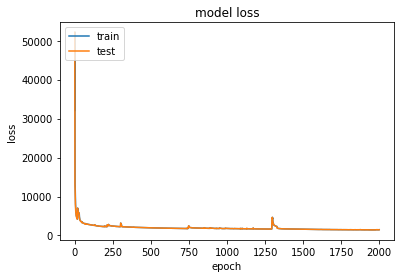

Done.
Test loss: 1471.89404296875
Test accuracy: 0.6916666626930237


In [40]:
X_train = X_train_tens[:, :, 0]
X_test = X_test_tens[:, :, 0]
X_val = X_val_tens[:, :, 0]
print(X_train_tens.shape)


# Parameters
N = X_train.shape[0]          # Number of nodes in the graph
F = X_train.shape[1]          # Original feature dimensionality
F_ = X_train.shape[1]         # Output dimension of first GraphAttention layer
n_attn_heads = 5              # Number of attention heads in first GAT layer
dropout_rate = 0            # Dropout rate applied to the input of GAT layers
l2_reg = 5e-100               # Regularization rate for l2
learning_rate = 5e-3       # Learning rate for SGD
epochs = 2000                # Number of epochs to run for
es_patience = 100             # Patience fot early stopping

print('N:', N)
print('F:', F)
print('F_:', F_)

# Model definition (as per Section 3.3 of the paper)
X_in = Input(shape=(F,))
A_in = Input(shape=(N,))

dropout1 = Dropout(dropout_rate)(X_in)
graph_attention_1 = GraphAttention(50,
                                   attn_heads=n_attn_heads,
                                   attn_heads_reduction='concat',
                                   attn_dropout=0,
                                   activation='linear',
                                   kernel_regularizer=l2(l2_reg))([dropout1, A_in])
dropout2 = Dropout(dropout_rate)(graph_attention_1)
graph_attention_2 = GraphAttention(50,
                                   attn_heads=n_attn_heads,
                                   attn_heads_reduction='concat',
                                   attn_dropout=0,
                                   activation='linear',
                                   kernel_regularizer=l2(l2_reg))([dropout2, A_in])
dense = Dense(8)(graph_attention_2)
#dropout3 = Dropout(dropout_rate)(graph_attention_2)
#graph_attention_3 = GraphAttention(F_,
#                                   attn_heads=n_attn_heads,
#                                   attn_heads_reduction='average',
#                                   attn_dropout=0,
#                                   activation='linear',
#                                   kernel_regularizer=l2(l2_reg))([dropout3, A_in])

# Build model
model = Model(inputs=[X_in, A_in], outputs=dense)
optimizer = Adagrad(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              weighted_metrics=['accuracy'])
model.summary()

# Callbacks
#es_callback = EarlyStopping(monitor='val_weighted_acc', patience=es_patience)
#tb_callback = TensorBoard(batch_size=N)

# Train model
validation_data = ([X_train, A], X_train)
history = model.fit([X_train, A],
          X_train,
          epochs=epochs,
          batch_size=N,
          validation_data = validation_data,
          shuffle=False,  # Shuffling data means shuffling the whole graph
         )

import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluate model
eval_results = model.evaluate([X_train, A],
                              X_train,
                              batch_size=N,
verbose=0)

print('Done.\n'
      'Test loss: {}\n'
'Test accuracy: {}'.format(*eval_results))




In [13]:
X_train.shape

(10,)

In [41]:
import pandas as pd
prediction = model.predict([X_train, A], batch_size = N)

#processed_data = pd.read_hdf('data/networks/simonnet/e1_detector_data_15_seconds.h5')
#processed_data
error = prediction - X_train

Visualization X_train:


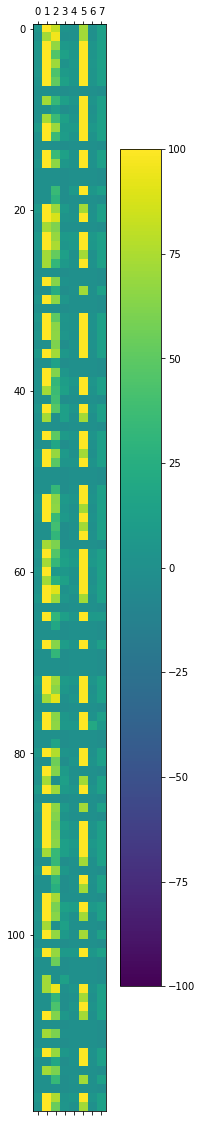

Visualization Prediction:


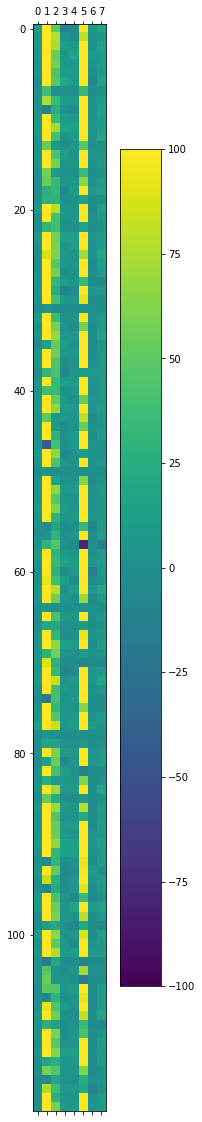

Visualization Error:


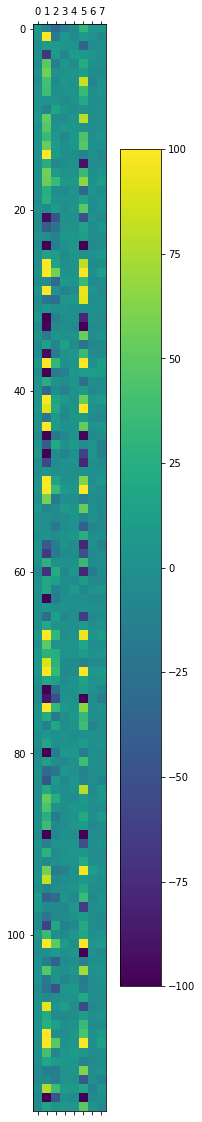

In [42]:
import matplotlib.pyplot as plt

print('Visualization X_train:')
fig = plt.figure(figsize=(5, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(X_train, vmin=-100, vmax=100)
fig.colorbar(cax)
plt.show()

print('Visualization Prediction:')
fig = plt.figure(figsize=(5, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(prediction, vmin=-100, vmax=100)
fig.colorbar(cax)
plt.show()

print('Visualization Error:')
fig = plt.figure(figsize=(5, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(error, vmin=-100, vmax=100)
fig.colorbar(cax)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 8)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                450       
_________________________________________________________________
dropout_79 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_80 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 408       
Total params: 3,408
Trainable params: 3,408
Non-trainable params: 0
_________________________________________________________________
Train on

Epoch 99/3000
120/120 [==============================] - 0s 154us/step - loss: 0.7260 - weighted_acc: 0.5083 - val_loss: 0.6921 - val_weighted_acc: 0.5083
Epoch 100/3000
120/120 [==============================] - 0s 154us/step - loss: 0.7251 - weighted_acc: 0.5083 - val_loss: 0.6912 - val_weighted_acc: 0.5083
Epoch 101/3000
120/120 [==============================] - 0s 154us/step - loss: 0.7243 - weighted_acc: 0.5083 - val_loss: 0.6902 - val_weighted_acc: 0.5083
Epoch 102/3000
120/120 [==============================] - 0s 142us/step - loss: 0.7234 - weighted_acc: 0.5083 - val_loss: 0.6893 - val_weighted_acc: 0.5083
Epoch 103/3000
120/120 [==============================] - 0s 138us/step - loss: 0.7225 - weighted_acc: 0.5083 - val_loss: 0.6883 - val_weighted_acc: 0.5083
Epoch 104/3000
120/120 [==============================] - 0s 100us/step - loss: 0.7217 - weighted_acc: 0.5083 - val_loss: 0.6875 - val_weighted_acc: 0.5083
Epoch 105/3000
120/120 [==============================] - 0s 178u

120/120 [==============================] - 0s 138us/step - loss: 0.6532 - weighted_acc: 0.5083 - val_loss: 0.6129 - val_weighted_acc: 0.5083
Epoch 204/3000
120/120 [==============================] - 0s 169us/step - loss: 0.6526 - weighted_acc: 0.5083 - val_loss: 0.6124 - val_weighted_acc: 0.5083
Epoch 205/3000
120/120 [==============================] - 0s 186us/step - loss: 0.6521 - weighted_acc: 0.5083 - val_loss: 0.6118 - val_weighted_acc: 0.5083
Epoch 206/3000
120/120 [==============================] - 0s 148us/step - loss: 0.6516 - weighted_acc: 0.5083 - val_loss: 0.6111 - val_weighted_acc: 0.5083
Epoch 207/3000
120/120 [==============================] - 0s 155us/step - loss: 0.6510 - weighted_acc: 0.5083 - val_loss: 0.6105 - val_weighted_acc: 0.5083
Epoch 208/3000
120/120 [==============================] - 0s 156us/step - loss: 0.6505 - weighted_acc: 0.5083 - val_loss: 0.6100 - val_weighted_acc: 0.5083
Epoch 209/3000
120/120 [==============================] - 0s 148us/step - loss:

120/120 [==============================] - 0s 146us/step - loss: 0.6043 - weighted_acc: 0.5083 - val_loss: 0.5591 - val_weighted_acc: 0.5083
Epoch 308/3000
120/120 [==============================] - 0s 137us/step - loss: 0.6039 - weighted_acc: 0.5083 - val_loss: 0.5587 - val_weighted_acc: 0.5083
Epoch 309/3000
120/120 [==============================] - 0s 127us/step - loss: 0.6035 - weighted_acc: 0.5083 - val_loss: 0.5583 - val_weighted_acc: 0.5083
Epoch 310/3000
120/120 [==============================] - 0s 141us/step - loss: 0.6031 - weighted_acc: 0.5083 - val_loss: 0.5579 - val_weighted_acc: 0.5083
Epoch 311/3000
120/120 [==============================] - 0s 148us/step - loss: 0.6028 - weighted_acc: 0.5083 - val_loss: 0.5574 - val_weighted_acc: 0.5083
Epoch 312/3000
120/120 [==============================] - 0s 128us/step - loss: 0.6023 - weighted_acc: 0.5083 - val_loss: 0.5570 - val_weighted_acc: 0.5083
Epoch 313/3000
120/120 [==============================] - 0s 144us/step - loss:

120/120 [==============================] - 0s 155us/step - loss: 0.5687 - weighted_acc: 0.5083 - val_loss: 0.5197 - val_weighted_acc: 0.5083
Epoch 412/3000
120/120 [==============================] - 0s 131us/step - loss: 0.5684 - weighted_acc: 0.5083 - val_loss: 0.5194 - val_weighted_acc: 0.5083
Epoch 413/3000
120/120 [==============================] - 0s 132us/step - loss: 0.5681 - weighted_acc: 0.5083 - val_loss: 0.5191 - val_weighted_acc: 0.5083
Epoch 414/3000
120/120 [==============================] - 0s 112us/step - loss: 0.5678 - weighted_acc: 0.5083 - val_loss: 0.5187 - val_weighted_acc: 0.5083
Epoch 415/3000
120/120 [==============================] - 0s 141us/step - loss: 0.5675 - weighted_acc: 0.5083 - val_loss: 0.5184 - val_weighted_acc: 0.5083
Epoch 416/3000
120/120 [==============================] - 0s 129us/step - loss: 0.5672 - weighted_acc: 0.5083 - val_loss: 0.5181 - val_weighted_acc: 0.5083
Epoch 417/3000
120/120 [==============================] - 0s 135us/step - loss:

120/120 [==============================] - 0s 110us/step - loss: 0.5412 - weighted_acc: 0.5083 - val_loss: 0.4891 - val_weighted_acc: 0.5083
Epoch 516/3000
120/120 [==============================] - 0s 115us/step - loss: 0.5409 - weighted_acc: 0.5083 - val_loss: 0.4887 - val_weighted_acc: 0.5083
Epoch 517/3000
120/120 [==============================] - 0s 128us/step - loss: 0.5406 - weighted_acc: 0.5083 - val_loss: 0.4885 - val_weighted_acc: 0.5083
Epoch 518/3000
120/120 [==============================] - 0s 128us/step - loss: 0.5404 - weighted_acc: 0.5083 - val_loss: 0.4883 - val_weighted_acc: 0.5083
Epoch 519/3000
120/120 [==============================] - 0s 135us/step - loss: 0.5402 - weighted_acc: 0.5083 - val_loss: 0.4880 - val_weighted_acc: 0.5083
Epoch 520/3000
120/120 [==============================] - 0s 132us/step - loss: 0.5400 - weighted_acc: 0.5083 - val_loss: 0.4877 - val_weighted_acc: 0.5083
Epoch 521/3000
120/120 [==============================] - 0s 132us/step - loss:

120/120 [==============================] - 0s 117us/step - loss: 0.5187 - weighted_acc: 0.5083 - val_loss: 0.4640 - val_weighted_acc: 0.5083
Epoch 620/3000
120/120 [==============================] - 0s 172us/step - loss: 0.5185 - weighted_acc: 0.5083 - val_loss: 0.4638 - val_weighted_acc: 0.5083
Epoch 621/3000
120/120 [==============================] - 0s 119us/step - loss: 0.5183 - weighted_acc: 0.5083 - val_loss: 0.4636 - val_weighted_acc: 0.5083
Epoch 622/3000
120/120 [==============================] - 0s 123us/step - loss: 0.5181 - weighted_acc: 0.5083 - val_loss: 0.4634 - val_weighted_acc: 0.5083
Epoch 623/3000
120/120 [==============================] - 0s 169us/step - loss: 0.5179 - weighted_acc: 0.5083 - val_loss: 0.4632 - val_weighted_acc: 0.5083
Epoch 624/3000
120/120 [==============================] - 0s 129us/step - loss: 0.5177 - weighted_acc: 0.5083 - val_loss: 0.4630 - val_weighted_acc: 0.5083
Epoch 625/3000
120/120 [==============================] - 0s 103us/step - loss:

120/120 [==============================] - 0s 156us/step - loss: 0.4996 - weighted_acc: 0.5083 - val_loss: 0.4430 - val_weighted_acc: 0.5083
Epoch 724/3000
120/120 [==============================] - 0s 140us/step - loss: 0.4994 - weighted_acc: 0.5083 - val_loss: 0.4428 - val_weighted_acc: 0.5083
Epoch 725/3000
120/120 [==============================] - 0s 148us/step - loss: 0.4992 - weighted_acc: 0.5083 - val_loss: 0.4426 - val_weighted_acc: 0.5083
Epoch 726/3000
120/120 [==============================] - 0s 152us/step - loss: 0.4991 - weighted_acc: 0.5083 - val_loss: 0.4424 - val_weighted_acc: 0.5083
Epoch 727/3000
120/120 [==============================] - 0s 158us/step - loss: 0.4989 - weighted_acc: 0.5083 - val_loss: 0.4422 - val_weighted_acc: 0.5083
Epoch 728/3000
120/120 [==============================] - 0s 192us/step - loss: 0.4987 - weighted_acc: 0.5083 - val_loss: 0.4420 - val_weighted_acc: 0.5083
Epoch 729/3000
120/120 [==============================] - 0s 178us/step - loss:

120/120 [==============================] - 0s 119us/step - loss: 0.4829 - weighted_acc: 0.5083 - val_loss: 0.4247 - val_weighted_acc: 0.5083
Epoch 828/3000
120/120 [==============================] - 0s 169us/step - loss: 0.4827 - weighted_acc: 0.5083 - val_loss: 0.4245 - val_weighted_acc: 0.5083
Epoch 829/3000
120/120 [==============================] - 0s 141us/step - loss: 0.4825 - weighted_acc: 0.5083 - val_loss: 0.4244 - val_weighted_acc: 0.5083
Epoch 830/3000
120/120 [==============================] - 0s 132us/step - loss: 0.4824 - weighted_acc: 0.5083 - val_loss: 0.4242 - val_weighted_acc: 0.5083
Epoch 831/3000
120/120 [==============================] - 0s 160us/step - loss: 0.4823 - weighted_acc: 0.5083 - val_loss: 0.4240 - val_weighted_acc: 0.5083
Epoch 832/3000
120/120 [==============================] - 0s 133us/step - loss: 0.4821 - weighted_acc: 0.5083 - val_loss: 0.4239 - val_weighted_acc: 0.5083
Epoch 833/3000
120/120 [==============================] - 0s 141us/step - loss:

120/120 [==============================] - 0s 181us/step - loss: 0.4679 - weighted_acc: 0.5083 - val_loss: 0.4085 - val_weighted_acc: 0.5083
Epoch 932/3000
120/120 [==============================] - 0s 248us/step - loss: 0.4678 - weighted_acc: 0.5083 - val_loss: 0.4084 - val_weighted_acc: 0.5083
Epoch 933/3000
120/120 [==============================] - 0s 175us/step - loss: 0.4676 - weighted_acc: 0.5083 - val_loss: 0.4083 - val_weighted_acc: 0.5083
Epoch 934/3000
120/120 [==============================] - 0s 148us/step - loss: 0.4675 - weighted_acc: 0.5083 - val_loss: 0.4081 - val_weighted_acc: 0.5083
Epoch 935/3000
120/120 [==============================] - 0s 139us/step - loss: 0.4674 - weighted_acc: 0.5083 - val_loss: 0.4080 - val_weighted_acc: 0.5083
Epoch 936/3000
120/120 [==============================] - 0s 158us/step - loss: 0.4672 - weighted_acc: 0.5083 - val_loss: 0.4078 - val_weighted_acc: 0.5083
Epoch 937/3000
120/120 [==============================] - 0s 148us/step - loss:

120/120 [==============================] - 0s 138us/step - loss: 0.4542 - weighted_acc: 0.5083 - val_loss: 0.3940 - val_weighted_acc: 0.5083
Epoch 1036/3000
120/120 [==============================] - 0s 119us/step - loss: 0.4541 - weighted_acc: 0.5083 - val_loss: 0.3939 - val_weighted_acc: 0.5083
Epoch 1037/3000
120/120 [==============================] - 0s 140us/step - loss: 0.4540 - weighted_acc: 0.5083 - val_loss: 0.3938 - val_weighted_acc: 0.5083
Epoch 1038/3000
120/120 [==============================] - 0s 153us/step - loss: 0.4539 - weighted_acc: 0.5083 - val_loss: 0.3936 - val_weighted_acc: 0.5083
Epoch 1039/3000
120/120 [==============================] - 0s 146us/step - loss: 0.4537 - weighted_acc: 0.5083 - val_loss: 0.3935 - val_weighted_acc: 0.5083
Epoch 1040/3000
120/120 [==============================] - 0s 151us/step - loss: 0.4536 - weighted_acc: 0.5083 - val_loss: 0.3934 - val_weighted_acc: 0.5083
Epoch 1041/3000
120/120 [==============================] - 0s 169us/step -

120/120 [==============================] - 0s 149us/step - loss: 0.4417 - weighted_acc: 0.5083 - val_loss: 0.3808 - val_weighted_acc: 0.5083
Epoch 1140/3000
120/120 [==============================] - 0s 121us/step - loss: 0.4415 - weighted_acc: 0.5083 - val_loss: 0.3807 - val_weighted_acc: 0.5083
Epoch 1141/3000
120/120 [==============================] - 0s 149us/step - loss: 0.4414 - weighted_acc: 0.5083 - val_loss: 0.3806 - val_weighted_acc: 0.5083
Epoch 1142/3000
120/120 [==============================] - 0s 139us/step - loss: 0.4413 - weighted_acc: 0.5083 - val_loss: 0.3805 - val_weighted_acc: 0.5083
Epoch 1143/3000
120/120 [==============================] - 0s 122us/step - loss: 0.4412 - weighted_acc: 0.5083 - val_loss: 0.3804 - val_weighted_acc: 0.5083
Epoch 1144/3000
120/120 [==============================] - 0s 167us/step - loss: 0.4411 - weighted_acc: 0.5083 - val_loss: 0.3803 - val_weighted_acc: 0.5083
Epoch 1145/3000
120/120 [==============================] - 0s 162us/step -

120/120 [==============================] - 0s 136us/step - loss: 0.4299 - weighted_acc: 0.5083 - val_loss: 0.3687 - val_weighted_acc: 0.5083
Epoch 1244/3000
120/120 [==============================] - 0s 165us/step - loss: 0.4298 - weighted_acc: 0.5083 - val_loss: 0.3686 - val_weighted_acc: 0.5083
Epoch 1245/3000
120/120 [==============================] - 0s 197us/step - loss: 0.4297 - weighted_acc: 0.5083 - val_loss: 0.3685 - val_weighted_acc: 0.5083
Epoch 1246/3000
120/120 [==============================] - 0s 138us/step - loss: 0.4296 - weighted_acc: 0.5083 - val_loss: 0.3684 - val_weighted_acc: 0.5083
Epoch 1247/3000
120/120 [==============================] - 0s 128us/step - loss: 0.4295 - weighted_acc: 0.5083 - val_loss: 0.3683 - val_weighted_acc: 0.5083
Epoch 1248/3000
120/120 [==============================] - 0s 110us/step - loss: 0.4294 - weighted_acc: 0.5083 - val_loss: 0.3682 - val_weighted_acc: 0.5083
Epoch 1249/3000
120/120 [==============================] - 0s 144us/step -

120/120 [==============================] - 0s 156us/step - loss: 0.4189 - weighted_acc: 0.5083 - val_loss: 0.3576 - val_weighted_acc: 0.5083
Epoch 1348/3000
120/120 [==============================] - 0s 162us/step - loss: 0.4188 - weighted_acc: 0.5083 - val_loss: 0.3574 - val_weighted_acc: 0.5083
Epoch 1349/3000
120/120 [==============================] - 0s 184us/step - loss: 0.4187 - weighted_acc: 0.5083 - val_loss: 0.3573 - val_weighted_acc: 0.5083
Epoch 1350/3000
120/120 [==============================] - 0s 138us/step - loss: 0.4186 - weighted_acc: 0.5083 - val_loss: 0.3572 - val_weighted_acc: 0.5083
Epoch 1351/3000
120/120 [==============================] - 0s 150us/step - loss: 0.4185 - weighted_acc: 0.5083 - val_loss: 0.3571 - val_weighted_acc: 0.5083
Epoch 1352/3000
120/120 [==============================] - 0s 162us/step - loss: 0.4184 - weighted_acc: 0.5083 - val_loss: 0.3570 - val_weighted_acc: 0.5083
Epoch 1353/3000
120/120 [==============================] - 0s 204us/step -

120/120 [==============================] - 0s 154us/step - loss: 0.4085 - weighted_acc: 0.5083 - val_loss: 0.3471 - val_weighted_acc: 0.5083
Epoch 1452/3000
120/120 [==============================] - 0s 164us/step - loss: 0.4084 - weighted_acc: 0.5083 - val_loss: 0.3470 - val_weighted_acc: 0.5083
Epoch 1453/3000
120/120 [==============================] - 0s 142us/step - loss: 0.4083 - weighted_acc: 0.5083 - val_loss: 0.3469 - val_weighted_acc: 0.5083
Epoch 1454/3000
120/120 [==============================] - 0s 154us/step - loss: 0.4082 - weighted_acc: 0.5083 - val_loss: 0.3468 - val_weighted_acc: 0.5083
Epoch 1455/3000
120/120 [==============================] - 0s 175us/step - loss: 0.4081 - weighted_acc: 0.5083 - val_loss: 0.3467 - val_weighted_acc: 0.5083
Epoch 1456/3000
120/120 [==============================] - 0s 134us/step - loss: 0.4080 - weighted_acc: 0.5083 - val_loss: 0.3466 - val_weighted_acc: 0.5083
Epoch 1457/3000
120/120 [==============================] - 0s 154us/step -

120/120 [==============================] - 0s 115us/step - loss: 0.3985 - weighted_acc: 0.5083 - val_loss: 0.3373 - val_weighted_acc: 0.5083
Epoch 1556/3000
120/120 [==============================] - 0s 165us/step - loss: 0.3984 - weighted_acc: 0.5083 - val_loss: 0.3372 - val_weighted_acc: 0.5083
Epoch 1557/3000
120/120 [==============================] - 0s 152us/step - loss: 0.3984 - weighted_acc: 0.5083 - val_loss: 0.3371 - val_weighted_acc: 0.5083
Epoch 1558/3000
120/120 [==============================] - 0s 139us/step - loss: 0.3982 - weighted_acc: 0.5083 - val_loss: 0.3370 - val_weighted_acc: 0.5083
Epoch 1559/3000
120/120 [==============================] - 0s 127us/step - loss: 0.3981 - weighted_acc: 0.5083 - val_loss: 0.3369 - val_weighted_acc: 0.5083
Epoch 1560/3000
120/120 [==============================] - 0s 130us/step - loss: 0.3981 - weighted_acc: 0.5083 - val_loss: 0.3368 - val_weighted_acc: 0.5083
Epoch 1561/3000
120/120 [==============================] - 0s 135us/step -

120/120 [==============================] - 0s 156us/step - loss: 0.3890 - weighted_acc: 0.5083 - val_loss: 0.3280 - val_weighted_acc: 0.5083
Epoch 1660/3000
120/120 [==============================] - 0s 133us/step - loss: 0.3890 - weighted_acc: 0.5083 - val_loss: 0.3279 - val_weighted_acc: 0.5083
Epoch 1661/3000
120/120 [==============================] - 0s 209us/step - loss: 0.3889 - weighted_acc: 0.5083 - val_loss: 0.3278 - val_weighted_acc: 0.5083
Epoch 1662/3000
120/120 [==============================] - 0s 316us/step - loss: 0.3888 - weighted_acc: 0.5083 - val_loss: 0.3277 - val_weighted_acc: 0.5083
Epoch 1663/3000
120/120 [==============================] - 0s 303us/step - loss: 0.3887 - weighted_acc: 0.5083 - val_loss: 0.3277 - val_weighted_acc: 0.5083
Epoch 1664/3000
120/120 [==============================] - 0s 194us/step - loss: 0.3886 - weighted_acc: 0.5083 - val_loss: 0.3276 - val_weighted_acc: 0.5083
Epoch 1665/3000
120/120 [==============================] - 0s 166us/step -

120/120 [==============================] - 0s 159us/step - loss: 0.3800 - weighted_acc: 0.5083 - val_loss: 0.3192 - val_weighted_acc: 0.5083
Epoch 1764/3000
120/120 [==============================] - 0s 175us/step - loss: 0.3798 - weighted_acc: 0.5083 - val_loss: 0.3191 - val_weighted_acc: 0.5083
Epoch 1765/3000
120/120 [==============================] - 0s 141us/step - loss: 0.3797 - weighted_acc: 0.5083 - val_loss: 0.3191 - val_weighted_acc: 0.5083
Epoch 1766/3000
120/120 [==============================] - 0s 182us/step - loss: 0.3797 - weighted_acc: 0.5083 - val_loss: 0.3190 - val_weighted_acc: 0.5083
Epoch 1767/3000
120/120 [==============================] - 0s 141us/step - loss: 0.3796 - weighted_acc: 0.5083 - val_loss: 0.3189 - val_weighted_acc: 0.5083
Epoch 1768/3000
120/120 [==============================] - 0s 267us/step - loss: 0.3795 - weighted_acc: 0.5083 - val_loss: 0.3188 - val_weighted_acc: 0.5083
Epoch 1769/3000
120/120 [==============================] - 0s 204us/step -

120/120 [==============================] - 0s 144us/step - loss: 0.3712 - weighted_acc: 0.5083 - val_loss: 0.3109 - val_weighted_acc: 0.5083
Epoch 1868/3000
120/120 [==============================] - 0s 184us/step - loss: 0.3711 - weighted_acc: 0.5083 - val_loss: 0.3108 - val_weighted_acc: 0.5083
Epoch 1869/3000
120/120 [==============================] - 0s 195us/step - loss: 0.3710 - weighted_acc: 0.5083 - val_loss: 0.3108 - val_weighted_acc: 0.5083
Epoch 1870/3000
120/120 [==============================] - 0s 188us/step - loss: 0.3710 - weighted_acc: 0.5083 - val_loss: 0.3107 - val_weighted_acc: 0.5083
Epoch 1871/3000
120/120 [==============================] - 0s 193us/step - loss: 0.3709 - weighted_acc: 0.5083 - val_loss: 0.3106 - val_weighted_acc: 0.5083
Epoch 1872/3000
120/120 [==============================] - 0s 163us/step - loss: 0.3708 - weighted_acc: 0.5083 - val_loss: 0.3105 - val_weighted_acc: 0.5083
Epoch 1873/3000
120/120 [==============================] - 0s 202us/step -

120/120 [==============================] - 0s 182us/step - loss: 0.3627 - weighted_acc: 0.5083 - val_loss: 0.3029 - val_weighted_acc: 0.5083
Epoch 1972/3000
120/120 [==============================] - 0s 146us/step - loss: 0.3626 - weighted_acc: 0.5083 - val_loss: 0.3028 - val_weighted_acc: 0.5083
Epoch 1973/3000
120/120 [==============================] - 0s 170us/step - loss: 0.3626 - weighted_acc: 0.5083 - val_loss: 0.3028 - val_weighted_acc: 0.5083
Epoch 1974/3000
120/120 [==============================] - 0s 170us/step - loss: 0.3625 - weighted_acc: 0.5083 - val_loss: 0.3026 - val_weighted_acc: 0.5083
Epoch 1975/3000
120/120 [==============================] - 0s 163us/step - loss: 0.3623 - weighted_acc: 0.5083 - val_loss: 0.3026 - val_weighted_acc: 0.5083
Epoch 1976/3000
120/120 [==============================] - 0s 163us/step - loss: 0.3623 - weighted_acc: 0.5083 - val_loss: 0.3025 - val_weighted_acc: 0.5083
Epoch 1977/3000
120/120 [==============================] - 0s 175us/step -

Epoch 2075/3000
120/120 [==============================] - 0s 152us/step - loss: 0.3545 - weighted_acc: 0.5083 - val_loss: 0.2953 - val_weighted_acc: 0.5083
Epoch 2076/3000
120/120 [==============================] - 0s 129us/step - loss: 0.3545 - weighted_acc: 0.5083 - val_loss: 0.2952 - val_weighted_acc: 0.5083
Epoch 2077/3000
120/120 [==============================] - 0s 143us/step - loss: 0.3544 - weighted_acc: 0.5083 - val_loss: 0.2951 - val_weighted_acc: 0.5083
Epoch 2078/3000
120/120 [==============================] - 0s 155us/step - loss: 0.3543 - weighted_acc: 0.5083 - val_loss: 0.2951 - val_weighted_acc: 0.5083
Epoch 2079/3000
120/120 [==============================] - 0s 188us/step - loss: 0.3543 - weighted_acc: 0.5083 - val_loss: 0.2950 - val_weighted_acc: 0.5083
Epoch 2080/3000
120/120 [==============================] - 0s 118us/step - loss: 0.3542 - weighted_acc: 0.5083 - val_loss: 0.2949 - val_weighted_acc: 0.5083
Epoch 2081/3000
120/120 [==============================] -

120/120 [==============================] - 0s 158us/step - loss: 0.3466 - weighted_acc: 0.5083 - val_loss: 0.2879 - val_weighted_acc: 0.5083
Epoch 2180/3000
120/120 [==============================] - 0s 159us/step - loss: 0.3466 - weighted_acc: 0.5083 - val_loss: 0.2878 - val_weighted_acc: 0.5083
Epoch 2181/3000
120/120 [==============================] - 0s 179us/step - loss: 0.3465 - weighted_acc: 0.5083 - val_loss: 0.2878 - val_weighted_acc: 0.5083
Epoch 2182/3000
120/120 [==============================] - 0s 147us/step - loss: 0.3464 - weighted_acc: 0.5083 - val_loss: 0.2877 - val_weighted_acc: 0.5083
Epoch 2183/3000
120/120 [==============================] - 0s 138us/step - loss: 0.3463 - weighted_acc: 0.5083 - val_loss: 0.2876 - val_weighted_acc: 0.5083
Epoch 2184/3000
120/120 [==============================] - 0s 153us/step - loss: 0.3462 - weighted_acc: 0.5083 - val_loss: 0.2876 - val_weighted_acc: 0.5083
Epoch 2185/3000
120/120 [==============================] - 0s 146us/step -

120/120 [==============================] - 0s 139us/step - loss: 0.3390 - weighted_acc: 0.5083 - val_loss: 0.2808 - val_weighted_acc: 0.5083
Epoch 2284/3000
120/120 [==============================] - 0s 150us/step - loss: 0.3389 - weighted_acc: 0.5083 - val_loss: 0.2808 - val_weighted_acc: 0.5083
Epoch 2285/3000
120/120 [==============================] - 0s 145us/step - loss: 0.3388 - weighted_acc: 0.5083 - val_loss: 0.2807 - val_weighted_acc: 0.5083
Epoch 2286/3000
120/120 [==============================] - 0s 125us/step - loss: 0.3387 - weighted_acc: 0.5083 - val_loss: 0.2806 - val_weighted_acc: 0.5083
Epoch 2287/3000
120/120 [==============================] - 0s 139us/step - loss: 0.3387 - weighted_acc: 0.5083 - val_loss: 0.2806 - val_weighted_acc: 0.5083
Epoch 2288/3000
120/120 [==============================] - 0s 139us/step - loss: 0.3386 - weighted_acc: 0.5083 - val_loss: 0.2805 - val_weighted_acc: 0.5083
Epoch 2289/3000
120/120 [==============================] - 0s 169us/step -

120/120 [==============================] - 0s 146us/step - loss: 0.3315 - weighted_acc: 0.5083 - val_loss: 0.2740 - val_weighted_acc: 0.5083
Epoch 2388/3000
120/120 [==============================] - 0s 120us/step - loss: 0.3314 - weighted_acc: 0.5083 - val_loss: 0.2739 - val_weighted_acc: 0.5083
Epoch 2389/3000
120/120 [==============================] - 0s 176us/step - loss: 0.3314 - weighted_acc: 0.5083 - val_loss: 0.2739 - val_weighted_acc: 0.5083
Epoch 2390/3000
120/120 [==============================] - 0s 129us/step - loss: 0.3313 - weighted_acc: 0.5083 - val_loss: 0.2738 - val_weighted_acc: 0.5083
Epoch 2391/3000
120/120 [==============================] - 0s 130us/step - loss: 0.3312 - weighted_acc: 0.5083 - val_loss: 0.2737 - val_weighted_acc: 0.5083
Epoch 2392/3000
120/120 [==============================] - 0s 163us/step - loss: 0.3311 - weighted_acc: 0.5083 - val_loss: 0.2737 - val_weighted_acc: 0.5083
Epoch 2393/3000
120/120 [==============================] - 0s 144us/step -

120/120 [==============================] - 0s 164us/step - loss: 0.3242 - weighted_acc: 0.5083 - val_loss: 0.2674 - val_weighted_acc: 0.5083
Epoch 2492/3000
120/120 [==============================] - 0s 172us/step - loss: 0.3242 - weighted_acc: 0.5083 - val_loss: 0.2674 - val_weighted_acc: 0.5083
Epoch 2493/3000
120/120 [==============================] - 0s 155us/step - loss: 0.3241 - weighted_acc: 0.5083 - val_loss: 0.2673 - val_weighted_acc: 0.5083
Epoch 2494/3000
120/120 [==============================] - 0s 126us/step - loss: 0.3240 - weighted_acc: 0.5083 - val_loss: 0.2672 - val_weighted_acc: 0.5083
Epoch 2495/3000
120/120 [==============================] - 0s 150us/step - loss: 0.3240 - weighted_acc: 0.5083 - val_loss: 0.2672 - val_weighted_acc: 0.5083
Epoch 2496/3000
120/120 [==============================] - 0s 177us/step - loss: 0.3239 - weighted_acc: 0.5083 - val_loss: 0.2671 - val_weighted_acc: 0.5083
Epoch 2497/3000
120/120 [==============================] - 0s 200us/step -

120/120 [==============================] - 0s 135us/step - loss: 0.3171 - weighted_acc: 0.5083 - val_loss: 0.2610 - val_weighted_acc: 0.5083
Epoch 2596/3000
120/120 [==============================] - 0s 116us/step - loss: 0.3171 - weighted_acc: 0.5083 - val_loss: 0.2609 - val_weighted_acc: 0.5083
Epoch 2597/3000
120/120 [==============================] - 0s 131us/step - loss: 0.3170 - weighted_acc: 0.5083 - val_loss: 0.2609 - val_weighted_acc: 0.5083
Epoch 2598/3000
120/120 [==============================] - 0s 140us/step - loss: 0.3169 - weighted_acc: 0.5083 - val_loss: 0.2608 - val_weighted_acc: 0.5083
Epoch 2599/3000
120/120 [==============================] - 0s 177us/step - loss: 0.3169 - weighted_acc: 0.5083 - val_loss: 0.2608 - val_weighted_acc: 0.5083
Epoch 2600/3000
120/120 [==============================] - 0s 116us/step - loss: 0.3168 - weighted_acc: 0.5083 - val_loss: 0.2607 - val_weighted_acc: 0.5083
Epoch 2601/3000
120/120 [==============================] - 0s 134us/step -

120/120 [==============================] - 0s 160us/step - loss: 0.3103 - weighted_acc: 0.5083 - val_loss: 0.2548 - val_weighted_acc: 0.5083
Epoch 2700/3000
120/120 [==============================] - 0s 151us/step - loss: 0.3102 - weighted_acc: 0.5083 - val_loss: 0.2547 - val_weighted_acc: 0.5083
Epoch 2701/3000
120/120 [==============================] - 0s 146us/step - loss: 0.3101 - weighted_acc: 0.5083 - val_loss: 0.2547 - val_weighted_acc: 0.5083
Epoch 2702/3000
120/120 [==============================] - 0s 123us/step - loss: 0.3101 - weighted_acc: 0.5083 - val_loss: 0.2546 - val_weighted_acc: 0.5083
Epoch 2703/3000
120/120 [==============================] - 0s 138us/step - loss: 0.3100 - weighted_acc: 0.5083 - val_loss: 0.2546 - val_weighted_acc: 0.5083
Epoch 2704/3000
120/120 [==============================] - 0s 154us/step - loss: 0.3100 - weighted_acc: 0.5083 - val_loss: 0.2545 - val_weighted_acc: 0.5083
Epoch 2705/3000
120/120 [==============================] - 0s 167us/step -

120/120 [==============================] - 0s 140us/step - loss: 0.3036 - weighted_acc: 0.5083 - val_loss: 0.2488 - val_weighted_acc: 0.5083
Epoch 2804/3000
120/120 [==============================] - 0s 156us/step - loss: 0.3035 - weighted_acc: 0.5083 - val_loss: 0.2488 - val_weighted_acc: 0.5083
Epoch 2805/3000
120/120 [==============================] - 0s 192us/step - loss: 0.3035 - weighted_acc: 0.5083 - val_loss: 0.2487 - val_weighted_acc: 0.5083
Epoch 2806/3000
120/120 [==============================] - 0s 189us/step - loss: 0.3034 - weighted_acc: 0.5083 - val_loss: 0.2486 - val_weighted_acc: 0.5083
Epoch 2807/3000
120/120 [==============================] - 0s 169us/step - loss: 0.3033 - weighted_acc: 0.5083 - val_loss: 0.2486 - val_weighted_acc: 0.5083
Epoch 2808/3000
120/120 [==============================] - 0s 129us/step - loss: 0.3033 - weighted_acc: 0.5083 - val_loss: 0.2485 - val_weighted_acc: 0.5083
Epoch 2809/3000
120/120 [==============================] - 0s 130us/step -

120/120 [==============================] - 0s 148us/step - loss: 0.2970 - weighted_acc: 0.5083 - val_loss: 0.2430 - val_weighted_acc: 0.5083
Epoch 2908/3000
120/120 [==============================] - 0s 161us/step - loss: 0.2970 - weighted_acc: 0.5083 - val_loss: 0.2429 - val_weighted_acc: 0.5083
Epoch 2909/3000
120/120 [==============================] - 0s 151us/step - loss: 0.2969 - weighted_acc: 0.5083 - val_loss: 0.2429 - val_weighted_acc: 0.5083
Epoch 2910/3000
120/120 [==============================] - 0s 153us/step - loss: 0.2968 - weighted_acc: 0.5083 - val_loss: 0.2428 - val_weighted_acc: 0.5083
Epoch 2911/3000
120/120 [==============================] - 0s 228us/step - loss: 0.2968 - weighted_acc: 0.5083 - val_loss: 0.2428 - val_weighted_acc: 0.5083
Epoch 2912/3000
120/120 [==============================] - 0s 160us/step - loss: 0.2968 - weighted_acc: 0.5083 - val_loss: 0.2427 - val_weighted_acc: 0.5083
Epoch 2913/3000
120/120 [==============================] - 0s 159us/step -

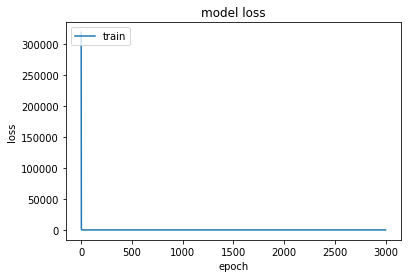

In [37]:
# Reference with normal neural net 
dropout_rate_dense = 0

layer1 = Dense(50)(X_in)
dropout1_dense = Dropout(dropout_rate_dense)(layer1)
layer2 = Dense(50)(dropout1_dense)
dropout2_dense = Dropout(dropout_rate_dense)(layer2)
layer3 = Dense(8)(dropout2_dense)
model_dense = Model(inputs=X_in, outputs=layer3)
model_dense.compile(optimizer=optimizer,
              loss='mean_squared_error',
              weighted_metrics=['accuracy'])
model_dense.summary()

validation_data = (X_train, X_train)
history_dense = model_dense.fit(X_train,
          X_train,
          epochs=epochs,
          batch_size=50,
          validation_data = validation_data,
          shuffle=False,  # Shuffling data means shuffling the whole graph
         )
plt.plot(history_dense.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluate model
eval_results = model_dense.evaluate(X_test,
                              X_test,
                              batch_size=50,
                              verbose=0)

Visualization X_train:


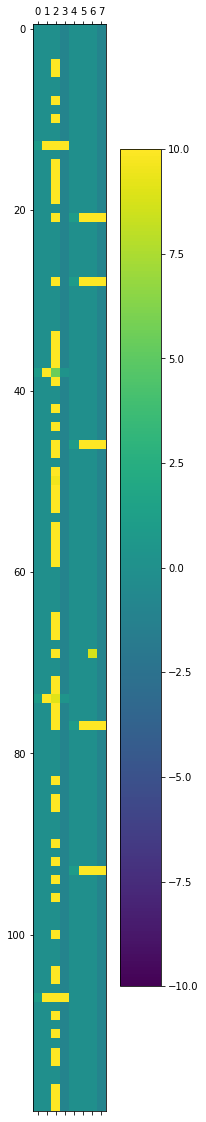

Visualization Prediction:


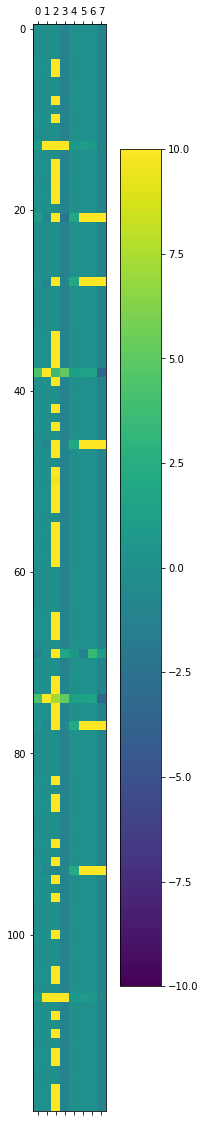

In [38]:
prediction_dense = model_dense.predict(X_train, batch_size = 10)


print('Visualization X_train:')
fig = plt.figure(figsize=(5, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(X_train, vmin=-10, vmax=10)
fig.colorbar(cax)
plt.show()

print('Visualization Prediction:')
fig = plt.figure(figsize=(5, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(prediction_dense, vmin=-10, vmax=10)
fig.colorbar(cax)
plt.show()